## Transformer-Based Sentiment Analysis

### Objectives

Implement a transformer-based sentiment analysis system using the Hugging Face ecosystem. This task will help you understand fine-tuning, evaluation, and interpretablility of transformer models for text classification.

### 1. Data Collection and Preprocessing (10 Points)

Choose a well-known sentiment analysis dataset from HuggingFace and perform text cleaning, tokenization, and data splitting into training, validation, and test sets.

Firstly, we'll import necessary libraries

In [2]:
# Consistency
# !pip uninstall torch torchvision transformers datasets -y
# Clear pip cache
# !pip cache purge
# !pip install torch torchvision transformers datasets --no-cache-dir

from datasets import load_dataset
from transformers import AutoTokenizer
import numpy as np
import torch

torch.cuda.is_available()

True

Load the IMDb dataset

In [2]:
# Load IMDb dataset from Hugging Face
imdb = load_dataset("imdb")

README.md:   0%|          | 0.00/7.81k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

unsupervised-00000-of-00001.parquet:   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Since IMDB dataset is huge, we'll create smaller datasets to enable faster training and testing

In [3]:
train_dataset = imdb["train"].shuffle(seed=42).select([i for i in list(range(6000))])
test_dataset = imdb["test"].shuffle(seed=42).select([i for i in list(range(600))])
# Split train into train and validation (80-20 split)
train_dataset = train_dataset.train_test_split(test_size=0.2)["train"]
valid_dataset = train_dataset.train_test_split(test_size=0.2)["test"]

To preprocess data, we use `DistilBERT tokenizer`

In [4]:
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

Prepare the text inputs for the model for splits

In [5]:
def preprocess_function(examples):
   return tokenizer(examples["text"], truncation=True)

tokenized_train = train_dataset.map(preprocess_function, batched=True)
tokenized_valid = valid_dataset.map(preprocess_function, batched=True)
tokenized_test = test_dataset.map(preprocess_function, batched=True)

Map:   0%|          | 0/4800 [00:00<?, ? examples/s]

Map:   0%|          | 0/960 [00:00<?, ? examples/s]

Map:   0%|          | 0/600 [00:00<?, ? examples/s]

To spped up training, use `data_collator` to convert training samples to PyTorch tensors and concatemate them with the correct amount of padding

In [6]:
from transformers import DataCollatorWithPadding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

### 2. Model Selection and Fine-Tuning

- Select a pre-trained transformer model (e.g. BERT, RoBERTa) from Hugging Face's model hub and fine-tune it on the chosen dataset using the Trainer API or a custom training loop.

- Experiment with hyperparameters like learning rate, batch size, and number of epochs.

Firstly, define DistilBERT as base model

In [7]:
from transformers import AutoModelForSequenceClassification
# Binary classification: positive/negative
model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-uncased", num_labels=2)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Then, we define metrics for evaluation

In [8]:
!pip install evaluate
import evaluate

def compute_metrics(eval_pred):
   load_accuracy = evaluate.load("accuracy")
   load_f1 = evaluate.load("f1")
   load_precision = evaluate.load("precision")
   load_recall = evaluate.load("recall")

   logits, labels = eval_pred
   predictions = np.argmax(logits, axis=-1)
   accuracy = load_accuracy.compute(predictions=predictions,
                                    references=labels)["accuracy"]
   f1 = load_f1.compute(predictions=predictions,
                        references=labels)["f1"]
   precision = load_precision.compute(predictions=predictions,
                                      references=labels)["precision"]
   recall = load_recall.compute(predictions=predictions,
                                references=labels)["recall"]
   return {"accuracy": accuracy, "precision": precision,
           "recall": recall, "f1": f1}

Now, login to HuggingFace account to manage model repos.

In [15]:
from huggingface_hub import notebook_login
notebook_login()

Now, define the training arguments and a Trainer

In [10]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
   output_dir= "assignment-3",
   learning_rate=2e-5,
   per_device_train_batch_size=16,
   per_device_eval_batch_size=16,
   num_train_epochs=2,
   # L2 Regularization
   weight_decay=0.01,
   save_strategy="epoch",
   push_to_hub=True,
   report_to="none"
)

trainer = Trainer(
   model=model,
   args=training_args,
   train_dataset=tokenized_train,
   eval_dataset=tokenized_valid,
   tokenizer=tokenizer,
   data_collator=data_collator,
   compute_metrics=compute_metrics,
)

<ipython-input-10-62aee62b1394>:16: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Now, start training the model

In [11]:
trainer.train()

/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


TrainOutput(global_step=300, training_loss=0.295328369140625, metrics={'train_runtime': 273.1387, 'train_samples_per_second': 35.147, 'train_steps_per_second': 1.098, 'total_flos': 1271165436715392.0, 'train_loss': 0.295328369140625, 'epoch': 2.0})

### 3. Evaluation and Benchmarking (10 Points)

-  Evaluate the model using metrics such as accuracy, precision, recall, and F1 score.

- Compare the performance with relevant baselines or published results.

Now, compute the evaluation matrics to see the model's performance

In [12]:
trainer.evaluate(tokenized_test)

/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'eval_loss': 0.2740614414215088,
 'eval_accuracy': 0.885,
 'eval_precision': 0.8688524590163934,
 'eval_recall': 0.9013605442176871,
 'eval_f1': 0.8848080133555926,
 'eval_runtime': 8.0144,
 'eval_samples_per_second': 74.865,
 'eval_steps_per_second': 2.371,
 'epoch': 2.0}

Now, we make comparison with the relevant baseline or publish results' performances

Since our model only used 3000 training data, we don't expect such a small-scaled one obtains a comparable performance compared with these outperforming models.

At this moment, we'll list some great models, which are all **trained on the same dataset**, while assuming that these models probably used the whole dataset:

|Model|Accuracy|F1|
|-----|--------|--------|
|RoBERTa|95.3|95.3|
|BERT| 94.0|94.1|
|DistilBERT| 93.4|93.5|
|CNN+LSTM| 88.8|...|
|**Ours (Finetuned DistilBERT)|88.5|88.48**|
|...|...|...|
|VGG16[vgg16]| 86|...|
|...|...|...|
|GPT|53.2|66.4|

* Resource: https://paperswithcode.com/sota/opinion-mining-on-imdb-movie-reviews?metric=F1

Frankly speaking, under this comparison, such a manual finetuned model with a small scale training and testing dataset obtained a pretty decent performance.

### 4. Visualization and Interpretability (10 Points)

- Generate visualizations (e.g. attention beatmaps, confusion matrices) to illustrate which tokens contribute most to the model's decisions.
- Analyze the visualizations to explain the model behavior and potential limitations.

Firstly, by using a sample, we showcase attention heatmap to see which tokens the model attends to most.

DistilBertSdpaAttention is used but `torch.nn.functional.scaled_dot_product_attention` does not support `output_attentions=True` or `head_mask`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


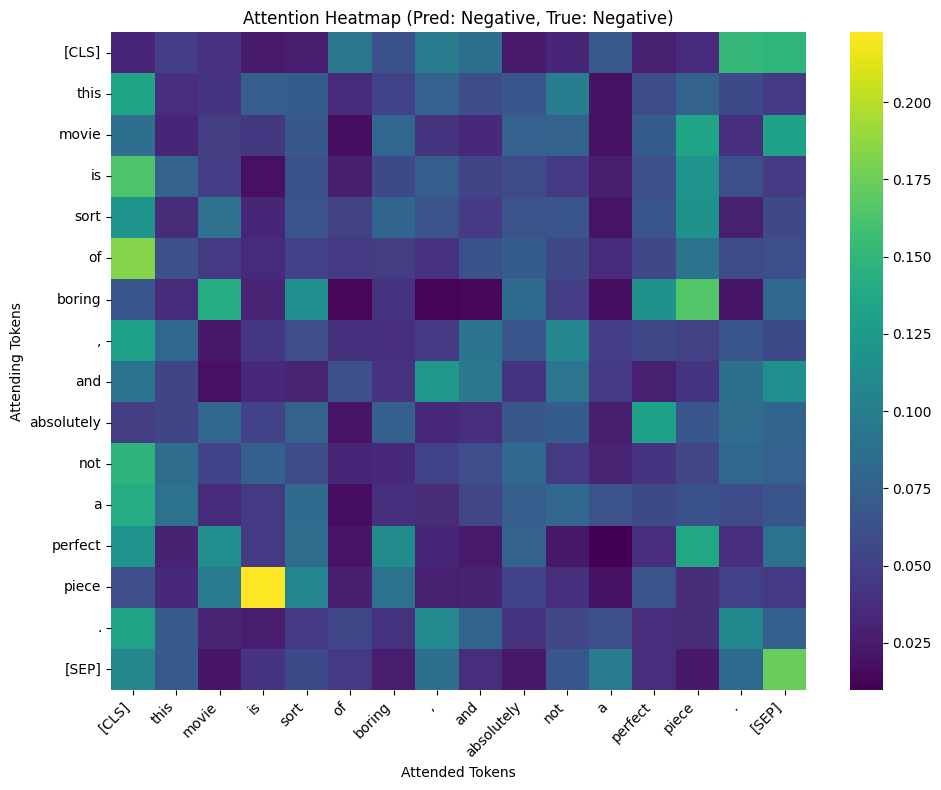

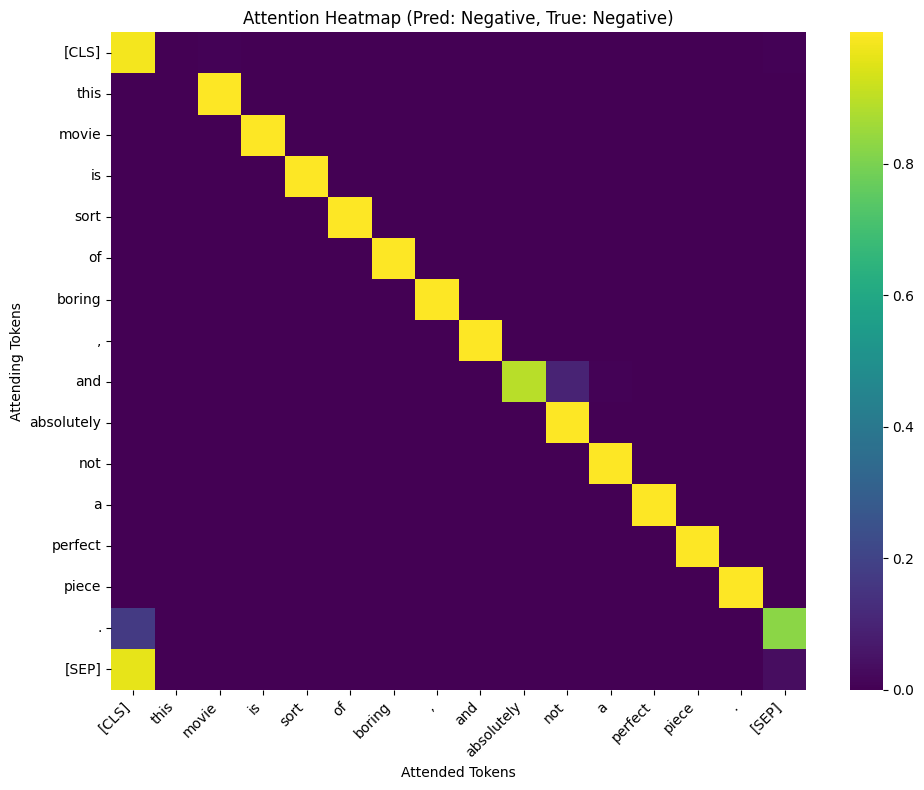

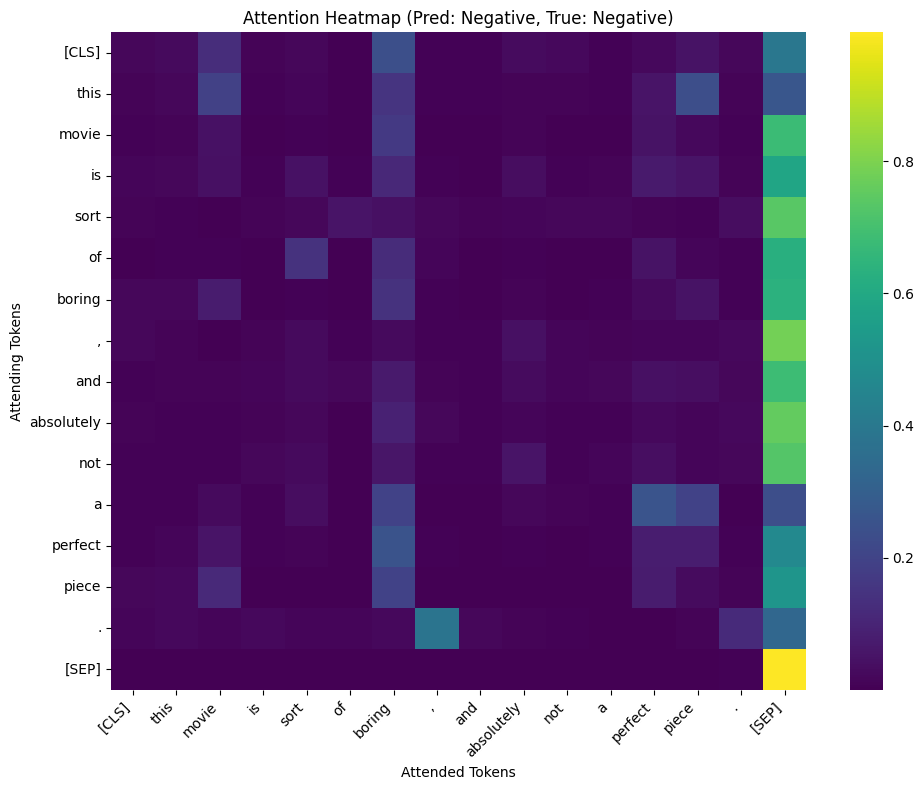

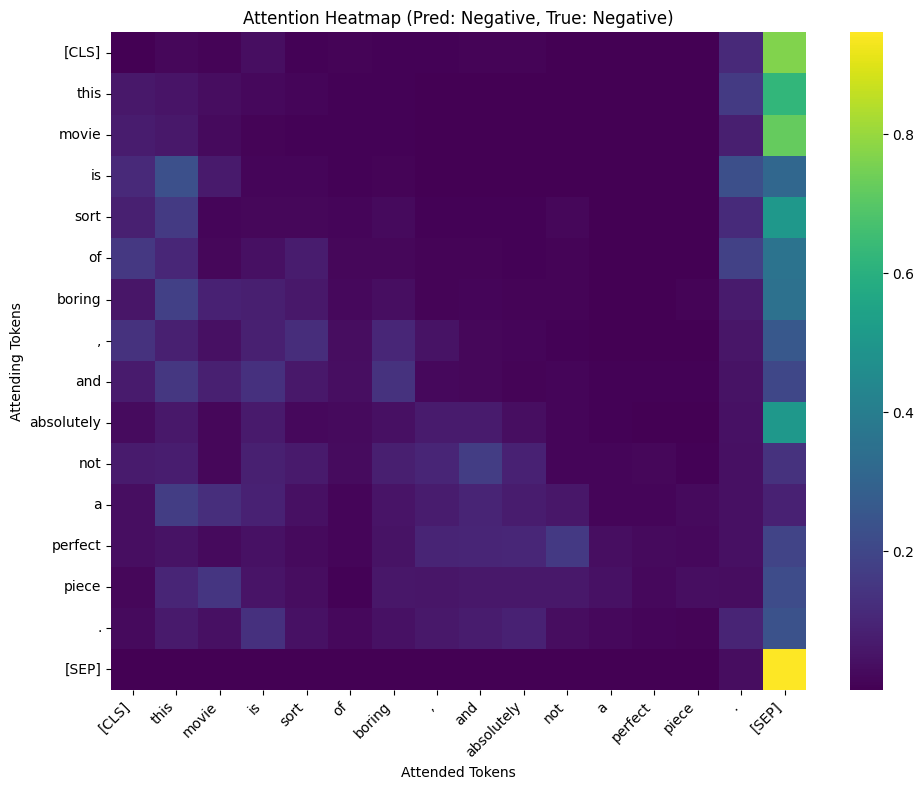

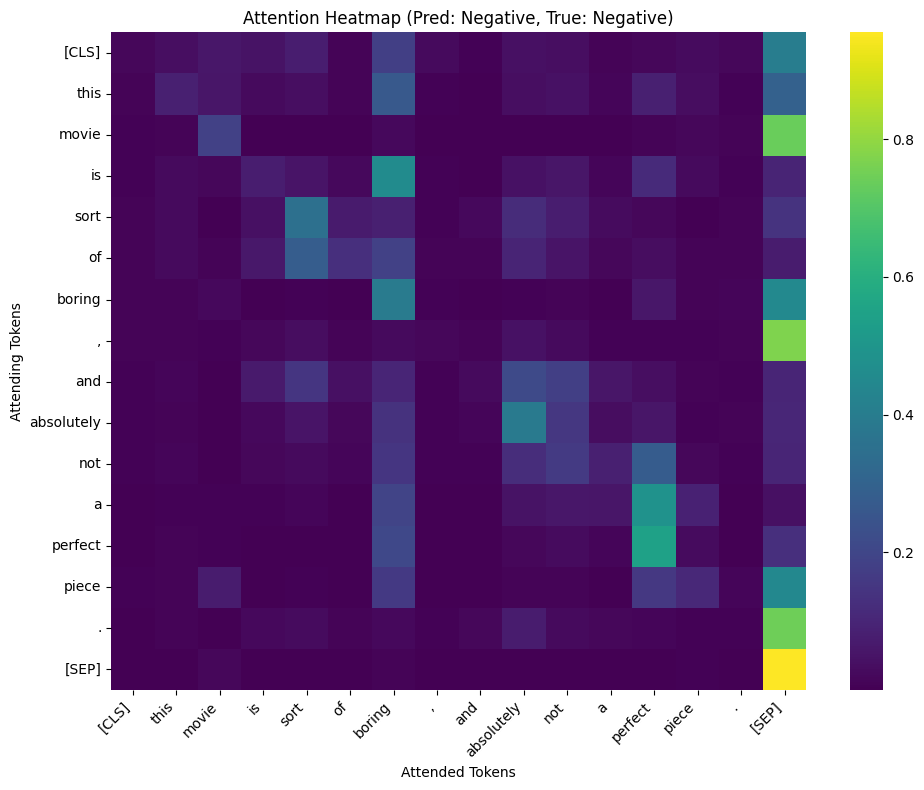

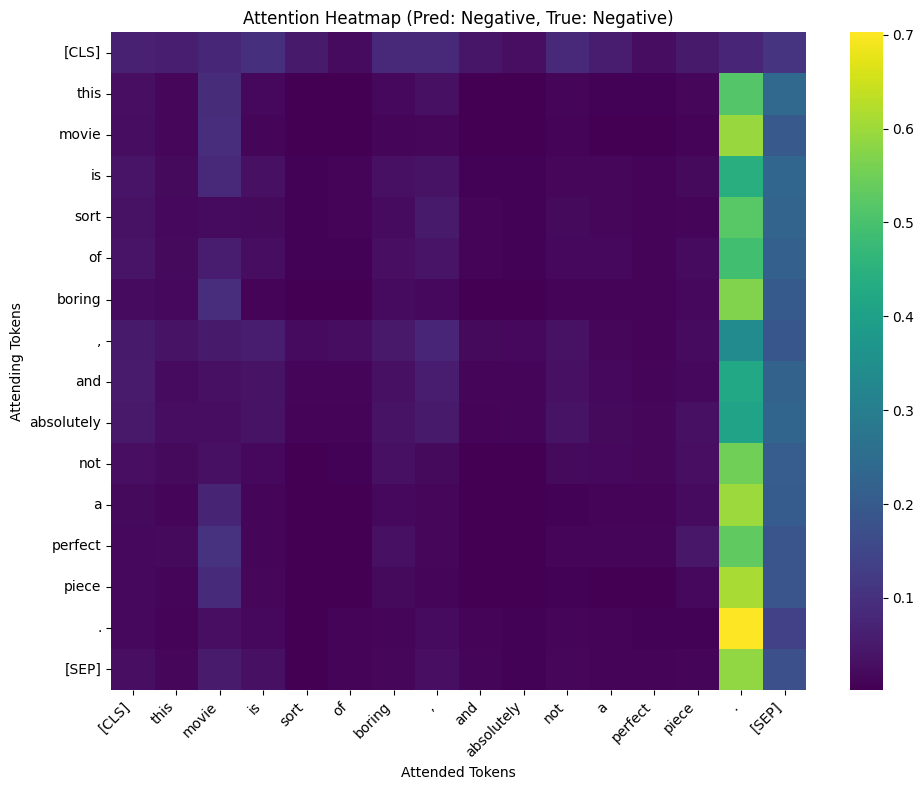

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

# Example
text = "This movie is sort of boring, and absolutely not a perfect piece."
#text = "boring, suck"
# Negative label
true_label = 0

# Tokenize and get attention weights
# return pytorch tensor, truncate and pad to ensure proper length
inputs = tokenizer(text, return_tensors="pt",
                   truncation=True, padding=True)
# Ensure that it's operating on the same device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# Move input to the same device
inputs = {k: v.to(device) for k, v in inputs.items()}
# Run the model, return attention weights for each layer
# Disable gradient computation for inference
with torch.no_grad():
  # ** unpacks the inputs dictionary into keyword arguments
  # turns from key:val to key=val
  outputs = model(**inputs, output_attentions=True)
# Extract attention weights and logits
# attentions is a tuple of tensors, one per layer
attentions = outputs.attentions
logits = outputs.logits
# Predict the sentiment class
prediction = logits.argmax(-1).item()

# Look through different layer's attention (layer -1, head 0)
# attention[***]: [batch_size, num_heads, seq_len, seq_len]
# [0,0] for batch 0 & head 0
# Get token labels for the heatmap
# Plot heatmap
for layer in range(len(attentions)):
    attention = attentions[layer][0, 0].cpu().numpy()
    tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])
    plt.figure(figsize=(10, 8))
    sns.heatmap(attention, xticklabels=tokens, yticklabels=tokens, cmap="viridis")
    plt.title(f"Attention Heatmap (Pred: {'Positive' if prediction == 1 else 'Negative'}, True: {'Positive' if true_label == 1 else 'Negative'})")
    plt.xlabel("Attended Tokens")
    plt.ylabel("Attending Tokens")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

The title indicates the model predicted `Negative`, which is correct.

However, through different figures, we could see that the **last but the second one** seems to be the most insightful one, as it shows highlights on these specific words like `boring`, `absolutely`, etc. that supposedly to show key info of semantics.

For the last layer, it probably has an issue of overfitting, which shifts the highlights to the punctuations instead.

Now, look at confusion matrix

/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


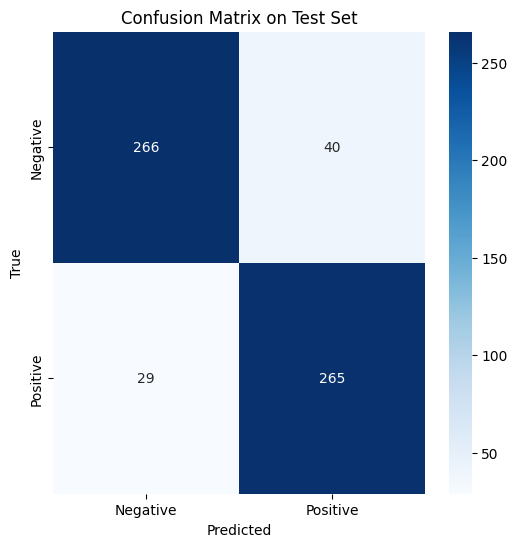

In [14]:
from sklearn.metrics import confusion_matrix

# Get predictions on test set
test_predictions = trainer.predict(tokenized_test)
# Predictions are logits, take argmax to get predicted classes
preds = test_predictions.predictions.argmax(-1)
true_labels = test_predictions.label_ids

# Compute confusion matrix
matrix = confusion_matrix(true_labels, preds, labels=[0,1])

# Plot
plt.figure(figsize=(6, 6))
sns.heatmap(matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.title("Confusion Matrix on Test Set")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

The confusion matrix has a great implication on the performance of the model, as it shows a high density on the correct predictions, and much less wrong cases.

### 5. Analysis and Reporting (5 Points)

-  Provide concise explanations detailing your methodology, experimental observations, challenges encountered, and insights gained from the visualization and evaluation.

For this manually created model, we finetuned DistilBERT with some common and basic hyperparameters, with a relatively tiny scale of training dataset by taking a subset from the profound `IMDB` dataset, which we have some relevant benchmark resource online to make comparison with.

It is probably possible to make an assumption that due to the lacking of more detail-oriented hyperparameters' finetuning and the limitation of the training dataset's scale, some unexpected scenarios like overfitting might occur. However, the general performance at the moment is still pretty good and impressive by the fact that how small the scale of model training is.

## Named Entity Recognition (NER) with Transformers

## Objectives

Implement a transformer-based NER system using the Hugging Face ecosystem. This task will help you understand fine-tuning transformer models for sequence labeling, manage token-label alignment, and analyze model behavior through visualization and error analysis.

### 1. Data Preparation (10 Points)

- Select a NER dataset and preprocess it by aligning tokens with entity labels, carefully handling cases of subwork tokenization.

For the dataset selection, we will choose `CoNLL-2003`, referring to `https://paperswithcode.com/dataset/conll-2003`, a named entity recognition dataset released as a part of CoNLL-2003 shared task: language-independent named entity recognition. The data consists of eight files covering two languages: English and German.

In [3]:
from datasets import load_dataset

# Load the dataset
dataset = load_dataset("conll2003")

print(dataset)

README.md:   0%|          | 0.00/12.3k [00:00<?, ?B/s]

conll2003.py:   0%|          | 0.00/9.57k [00:00<?, ?B/s]

The repository for conll2003 contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/conll2003.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N]  y


Generating train split:   0%|          | 0/14041 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3250 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/3453 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 14041
    })
    validation: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 3250
    })
    test: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 3453
    })
})


What we see above is the structure of the dataset, we can try to scope an example entry.

In [4]:
print(dataset["train"][0])

{'id': '0', 'tokens': ['EU', 'rejects', 'German', 'call', 'to', 'boycott', 'British', 'lamb', '.'], 'pos_tags': [22, 42, 16, 21, 35, 37, 16, 21, 7], 'chunk_tags': [11, 21, 11, 12, 21, 22, 11, 12, 0], 'ner_tags': [3, 0, 7, 0, 0, 0, 7, 0, 0]}


It contains sentences with token-level NER labels in IOB format (e.g. `B-PER: beginning of a person entity`, `0: outside`, etc.)
- Entities: PER (Person), ORG (Organization), LOC (Location), MISC (Miscellaneous)
- Label Format: IOB2 (e.g. `B-PER`, etc.)
- Dataset Splits: Train (14041), Validation(3250), Test(3453)

Referring to `https://huggingface.co/datasets/eriktks/conll2003/blob/main/README.md#dataset-summary`, the dataset uses IOB2. Map the `ner-tags`, which should generate a same output as a list of classification labels (int) from the referred link.

In [5]:
label_list = [
    "O",       # Outside of a named entity
    "B-PER",   # Beginning of a person
    "I-PER",   # Inside a person
    "B-ORG",   # Beginning of an organization
    "I-ORG",   # Inside an organization
    "B-LOC",   # Beginning of a location
    "I-LOC",   # Inside a location
    "B-MISC",  # Beginning of a miscellaneous entity
    "I-MISC"   # Inside a miscellaneous entity
]

label2id = {label: i for i, label in enumerate(label_list)}
id2label = {i: label for i, label in enumerate(label_list)}

print("Label mapping:", label2id)

Label mapping: {'O': 0, 'B-PER': 1, 'I-PER': 2, 'B-ORG': 3, 'I-ORG': 4, 'B-LOC': 5, 'I-LOC': 6, 'B-MISC': 7, 'I-MISC': 8}


For the preprocessing step, we refer to this page from huggingface `https://huggingface.co/docs/transformers/en/tasks/token_classification`

NER is a token-level classification task, but transformers like `DistilBERT` use subword tokenization. This creates a mismatch between the dataset's tokens and the model's tokenized inputs. We need to align the NER labels with the subword tokens. For example:
- Subword tokens (E.g. `##ing` in `boring`) inherit the label of the first token
- Special tokens (E.g. `[CLS], [SEP]`) are labeled with `-100` [`CrossEntropyLoss` referred]

In [6]:
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

It is needed to set `is_split_into_words=True` to tokenize the words into subwords. For example:

In [7]:
example=dataset["train"][0]
tokenized_input = tokenizer(example["tokens"], is_split_into_words=True)
tokens=tokenizer.convert_ids_to_tokens(tokenized_input["input_ids"])
tokens

['[CLS]',
 'eu',
 'rejects',
 'german',
 'call',
 'to',
 'boycott',
 'british',
 'lamb',
 '.',
 '[SEP]']

Now we create a function to realign the tokens and labels, and truncate sequences to be no longer than the original model's max input length

In [25]:
def tokenize_and_align_labels(examples):
  # Tokenize the inputs
  tokenized_inputs = tokenizer(
      examples["tokens"],
      truncation=True,
      is_split_into_words=True,
      padding=True,
      return_tensors="pt"
  )

  labels=[]
  for i, label in enumerate(examples["ner_tags"]):
    # Map tokens to their respective word
    word_ids = tokenized_inputs.word_ids(batch_index=i)
    previous_word_idx=None
    label_ids = []

    for word_idx in word_ids:
      # Special tokens
      if word_idx is None:
        label_ids.append(-100)
      elif word_idx != previous_word_idx:
        label_ids.append(label[word_idx])
      # Subword continuation
      else:
        # If the label is B- (Before), convert to I- (Inside)
        current_label = label[word_idx]
        # B- labels are odd
        if current_label % 2 == 1:
          label_ids.append(current_label + 1)
        else:
          # Keep I- label of 0
          label_ids.append(current_label)
      previous_word_idx = word_idx

    labels.append(label_ids)

  tokenized_inputs["labels"] = labels
  return tokenized_inputs

Then we apply this tokenization and label alignment to the dataset, with a sample inspection

In [26]:
tokenized_datasets = dataset.map(tokenize_and_align_labels, batched = True)
print(tokenized_datasets["train"][0])

Map:   0%|          | 0/14041 [00:00<?, ? examples/s]

Map:   0%|          | 0/3250 [00:00<?, ? examples/s]

Map:   0%|          | 0/3453 [00:00<?, ? examples/s]

{'id': '0', 'tokens': ['EU', 'rejects', 'German', 'call', 'to', 'boycott', 'British', 'lamb', '.'], 'pos_tags': [22, 42, 16, 21, 35, 37, 16, 21, 7], 'chunk_tags': [11, 21, 11, 12, 21, 22, 11, 12, 0], 'ner_tags': [3, 0, 7, 0, 0, 0, 7, 0, 0], 'input_ids': [101, 7327, 19164, 2446, 2655, 2000, 17757, 2329, 12559, 1012, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'labels': [-100, 3, 0, 7, 0, 0, 0, 7, 0, 0, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100

It would be good to remove unnecessary columns and set the format for PyTorch tensors

In [27]:
tokenized_datasets = tokenized_datasets.remove_columns([
    "id", "tokens", "pos_tags", "chunk_tags", "ner_tags"])
tokenized_datasets.set_format("torch")

# Verify
print(tokenized_datasets["train"][0])

{'input_ids': tensor([  101,  7327, 19164,  2446,  2655,  2000, 17757,  2329, 12559,  1012,
          102,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0]), 'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0]), 'labels': tensor([-100,    3,    0,    7,    0,    0,    0,    7,    0,    0, -100, -100,
        

### 2. Model Setup and Fine-Tuning (15 Points)
- Choose an appropriate pre-trained transformer model (e.g., BERT, RoBERTa) from Hugging Face and fine-tune it on the NER dataset.
- Implement strategies to addresss token-label alignment challenges during training.

Since NER is a token classification task, we use `AutoModelForTokenClassification`:

In [11]:
from transformers import AutoModelForTokenClassification

model = AutoModelForTokenClassification.from_pretrained(
    "distilbert-base-uncased",
    num_labels=len(label_list),
    id2label=id2label,
    label2id=label2id
)

# Use GPU if possible
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForTokenClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DistilBertForTokenClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
   

Using `DataCollatorForTokenClassification` to ensure the correctly padding and alignment's preservation.

In [12]:
from transformers import DataCollatorForTokenClassification

# Instantiate the collator
data_collator = DataCollatorForTokenClassification(tokenizer)

Now, use the `Trainer` API to fine-tune the model, incorporating the custom collator and training arguments.

In [28]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    output_dir = "assignment-3",
    evaluation_strategy = "epoch",
    learning_rate = 2e-5,
    per_device_train_batch_size = 16,
    per_device_eval_batch_size = 16,
    num_train_epochs = 3,
    weight_decay = 0.01,
    save_strategy = "epoch",
    load_best_model_at_end = True,
    push_to_hub=True,
    report_to="none"
)

trainer = Trainer(
    model=model,
    args = training_args,
    train_dataset = tokenized_datasets["train"],
    eval_dataset = tokenized_datasets["validation"],
    data_collator = data_collator,
    tokenizer = tokenizer
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-28-92c83d5a7a07>:17: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [17]:
# Train the model
trainer.train()

/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,No log,0.076167
2,0.205600,0.058629
3,0.053300,0.058175


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
No files have been modified since last commit. Skipping to prevent empty commit.


TrainOutput(global_step=1317, training_loss=0.10746027903748717, metrics={'train_runtime': 403.9111, 'train_samples_per_second': 104.288, 'train_steps_per_second': 3.261, 'total_flos': 1691840015699400.0, 'train_loss': 0.10746027903748717, 'epoch': 3.0})

### 3. Evaluation and Metrics (10 Points)

- Evaluate the model using entity-level precision, recall, and F1 scores.
- Perform error analysis to identify common misclassifications and areas for improvement.

`seqeval` metric will be used for computing entity-level precision, recall, and F1 scores based on IOB2 labels.

In [18]:
!pip install evaluate
!pip install seqeval
import evaluate
import numpy as np

metric = evaluate.load("seqeval")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 1.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16161 sha256=d58a0641def49a526aba5d362a066d47c503aefd3a40b1b03bcae34a201ef1b3
  Stored in directory: /root/.cache/pip/wheels/1a/67/4a/ad4082dd7dfc30f2abfe4d80a2ed5926a506eb8a972b4767fa
Successfully built seqeval


Now using the `Trainer` to evaluate the model on the test set and compute entity-level metrics

In [19]:
def compute_metrics(pred):
    predictions, labels = pred
    predictions = np.argmax(predictions, axis = 2)
    
    # Remove ignored indices (-100) and align with original tokens
    true_labels = []
    true_predictions = []
    for i in range(len(labels)):
        true_label = []
        pred_label = []
        for j in range(len(labels[i])):
            if labels[i][j] != -100:
                true_label.append(label_list[labels[i][j]])
                pred_label.append(label_list[predictions[i][j]])
            true_labels.append(true_label)
            true_predictions.append(pred_label)
        
    # Compute entity-level metrics
    results = metric.compute(predictions = true_predictions, references = true_labels)
    return {
        "precision": results["overall_precision"],
        "recall": results["overall_recall"],
        "f1": results["overall_f1"],
        "accuracy": results["overall_accuracy"]
    }

# Trainer for evaluation
data_collator = DataCollatorForTokenClassification(tokenizer)
trainer = Trainer(
    model = model,
    args = training_args,
    eval_dataset = tokenized_datasets["test"],
    data_collator = data_collator,
    tokenizer = tokenizer,
    compute_metrics = compute_metrics
)

<ipython-input-19-fee65f5a3c2f>:29: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [20]:
# Evaluate the model
eval_results = trainer.evaluate()
print("Evaluation Results:", eval_results)

/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Evaluation Results: {'eval_loss': 0.1152232214808464, 'eval_precision': 0.8555821099351314, 'eval_recall': 0.8873937677053825, 'eval_f1': 0.8711976360159915, 'eval_accuracy': 0.9738968303293971, 'eval_runtime': 168.1683, 'eval_samples_per_second': 20.533, 'eval_steps_per_second': 0.642}


- Precision: 85.473%
- Recall: 88.969%
- F1: 87.187%
- *F1 reflects entity-level performance, accounting for correct span detection*
- Accuracy: 97.419%

The result is quite decent. And such a performance technically is expected.

Now, perform an error analysis to identify common misclassifications and areas for improvement

In [21]:
# Get predictions for the entire test set
predictions, labels, _ = trainer.predict(tokenized_datasets["test"])
predictions = np.argmax(predictions, axis=2)

# Align predictions and labels
true_labels_all = []
pred_labels_all = []
tokens_all = []
for i in range(len(labels)):
    true_label = []
    pred_label = []
    tokens = dataset["test"][i]["tokens"]
    word_ids = tokenized_datasets["test"][i]["input_ids"].ne(tokenizer.pad_token_id).nonzero().tolist()
    for j in range(len(labels[i])):
        if labels[i][j] != -100:
            true_label.append(label_list[labels[i][j]])
            pred_label.append(label_list[predictions[i][j]])
    true_labels_all.append(true_label)
    pred_labels_all.append(pred_label)
    tokens_all.append(tokens)

# Find misclassified examples
misclassified_examples = []
for i, (true, pred, tokens) in enumerate(zip(true_labels_all, pred_labels_all, tokens_all)):
    if true != pred:
        misclassified_examples.append((i, tokens, true, pred))

print(f"Number of misclassified examples: {len(misclassified_examples)} out of {len(true_labels_all)}")

Number of misclassified examples: 648 out of 3453


As we can see, the number of misclassified examples takes 1/6 to 1/5 of the total number of examples.

Examine the first few misclassified examples to identify patterns and see how mistakes are maken.

In [22]:
# Print the first 5 misclassified examples
for i, tokens, true_labels, pred_labels in misclassified_examples[:5]:
    print(f"Example {i}:")
    print("Tokens:", tokens)
    print("True Labels:", true_labels)
    print("Predicted Labels:", pred_labels)
    print("Misclassifications:", [(t, p) for t, p in zip(true_labels, pred_labels) if t != p])
    print()

Example 0:
Tokens: ['SOCCER', '-', 'JAPAN', 'GET', 'LUCKY', 'WIN', ',', 'CHINA', 'IN', 'SURPRISE', 'DEFEAT', '.']
True Labels: ['O', 'O', 'B-LOC', 'O', 'O', 'O', 'O', 'B-PER', 'O', 'O', 'O', 'O']
Predicted Labels: ['O', 'O', 'B-LOC', 'O', 'O', 'O', 'O', 'B-LOC', 'O', 'O', 'O', 'O']
Misclassifications: [('B-PER', 'B-LOC')]

Example 5:
Tokens: ['China', 'controlled', 'most', 'of', 'the', 'match', 'and', 'saw', 'several', 'chances', 'missed', 'until', 'the', '78th', 'minute', 'when', 'Uzbek', 'striker', 'Igor', 'Shkvyrin', 'took', 'advantage', 'of', 'a', 'misdirected', 'defensive', 'header', 'to', 'lob', 'the', 'ball', 'over', 'the', 'advancing', 'Chinese', 'keeper', 'and', 'into', 'an', 'empty', 'net', '.']
True Labels: ['B-LOC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-MISC', 'I-MISC', 'O', 'B-PER', 'I-PER', 'I-PER', 'I-PER', 'I-PER', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-MISC', 'O', 'O', 'O

For example, we could see:

- In the first example, `CHINA` has a misclassification, with a given prediction `B-LOC` corresponding to the true label `B-PER`, where the correct answer seems not to be the one that makes sense.

- Where in the Example 28, `cup` is not successfully classified, which drives the occurrence of the errors.

- ...

The way that mistakes are made is somehow dynamic, and some of the mistakes seems not to be the prediction's mistakes.

### 4. Visualization and Interpretation (10 Points)
- Create visualizations such as attention maps or confusion matrices to demostrate how the model distinguishes between entities.
- Use these visualizations to provide insights into model strenghts and weaknesses.

Heatmap is selected to scope the performance of the model.

DistilBertSdpaAttention is used but `torch.nn.functional.scaled_dot_product_attention` does not support `output_attentions=True` or `head_mask`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


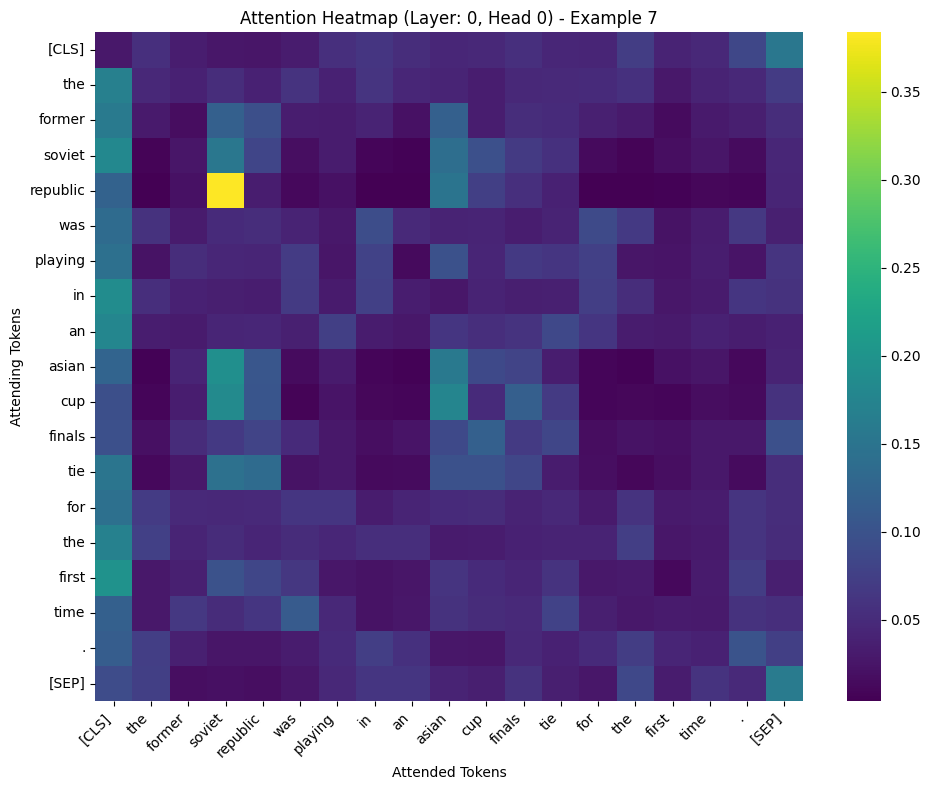

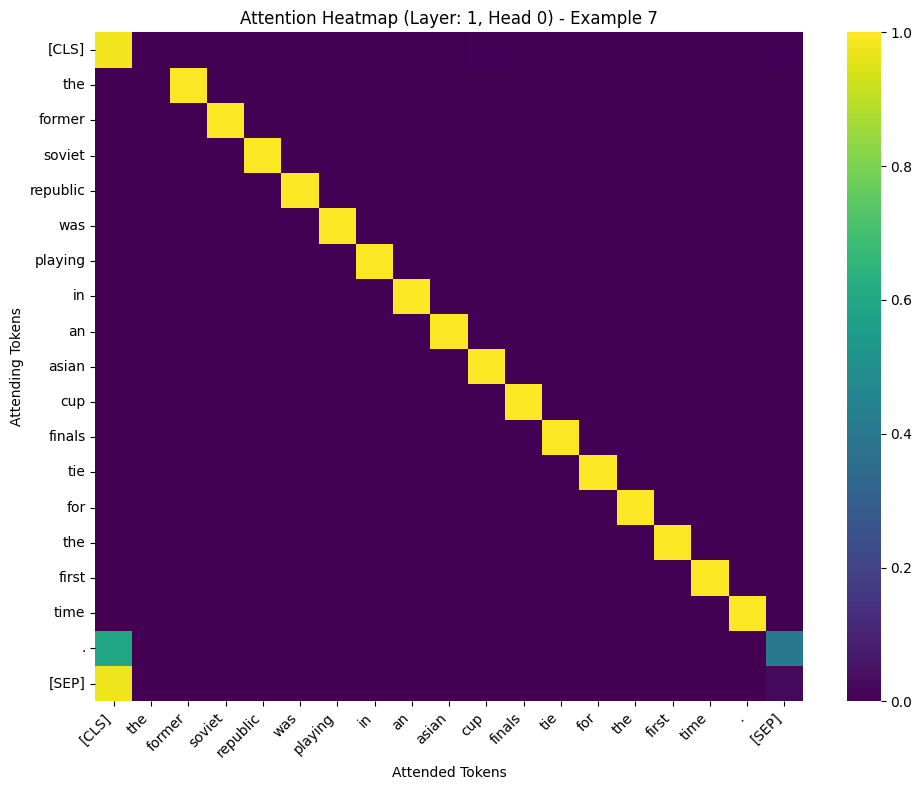

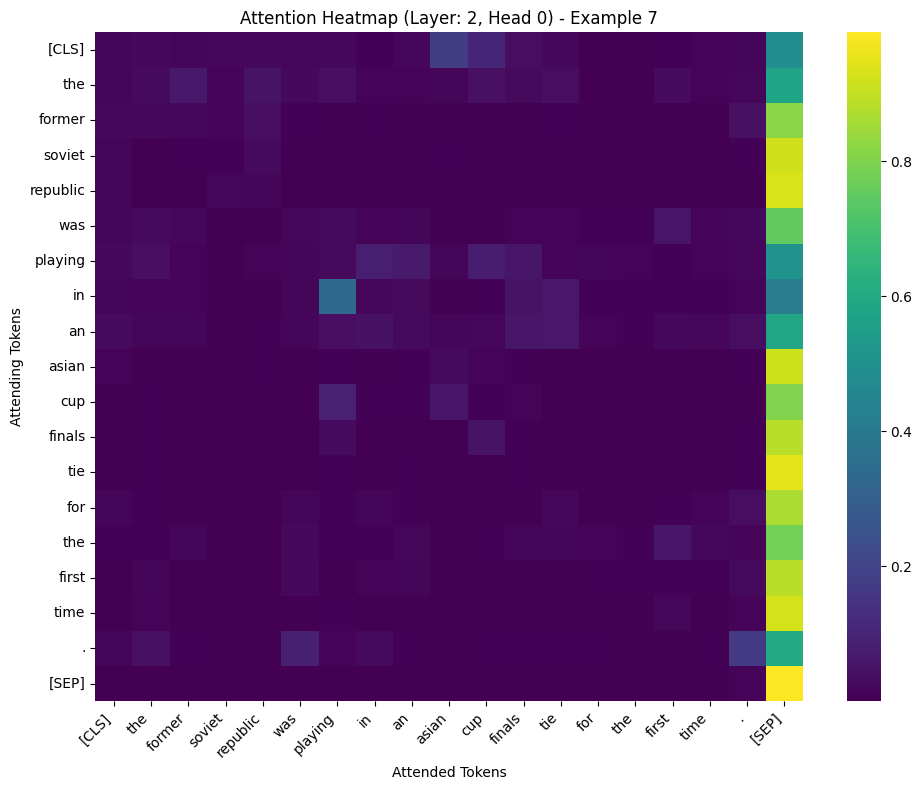

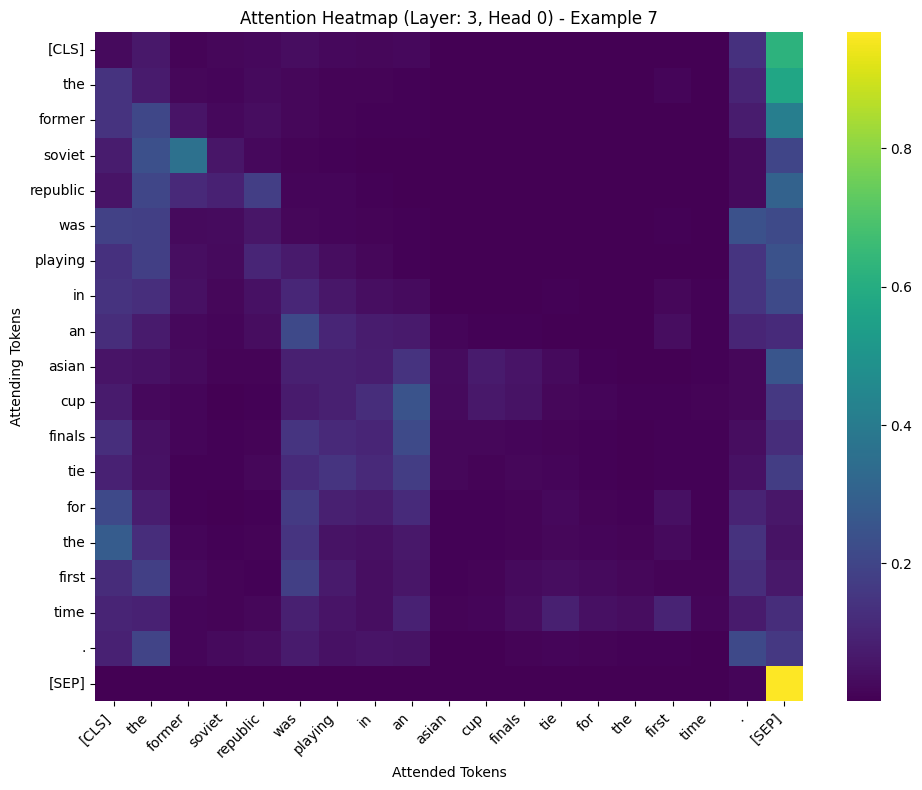

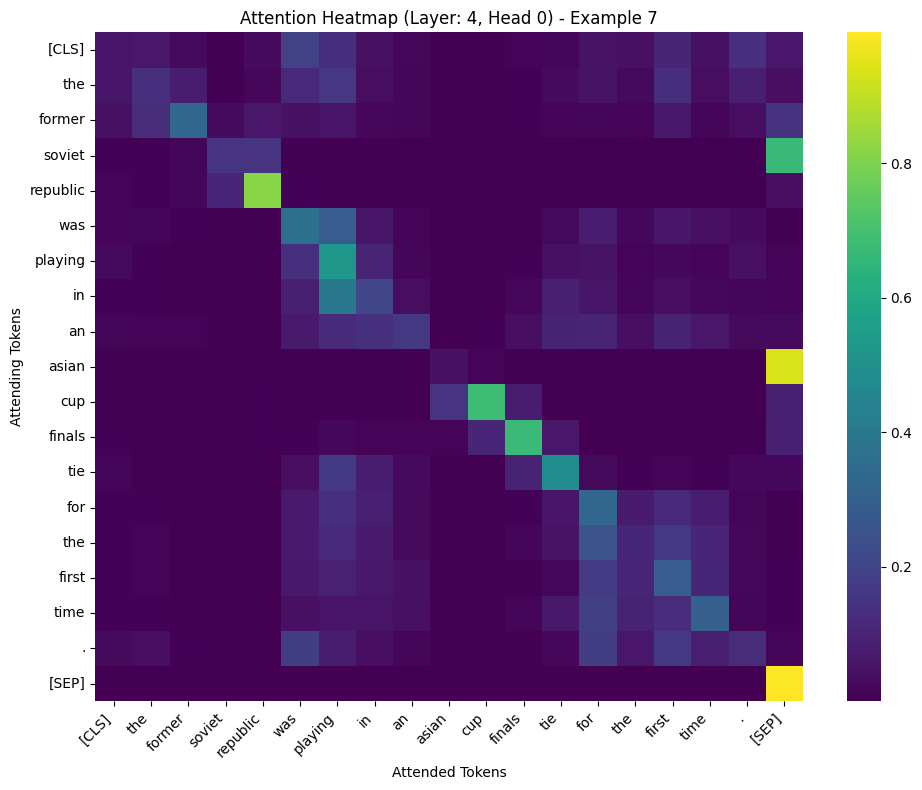

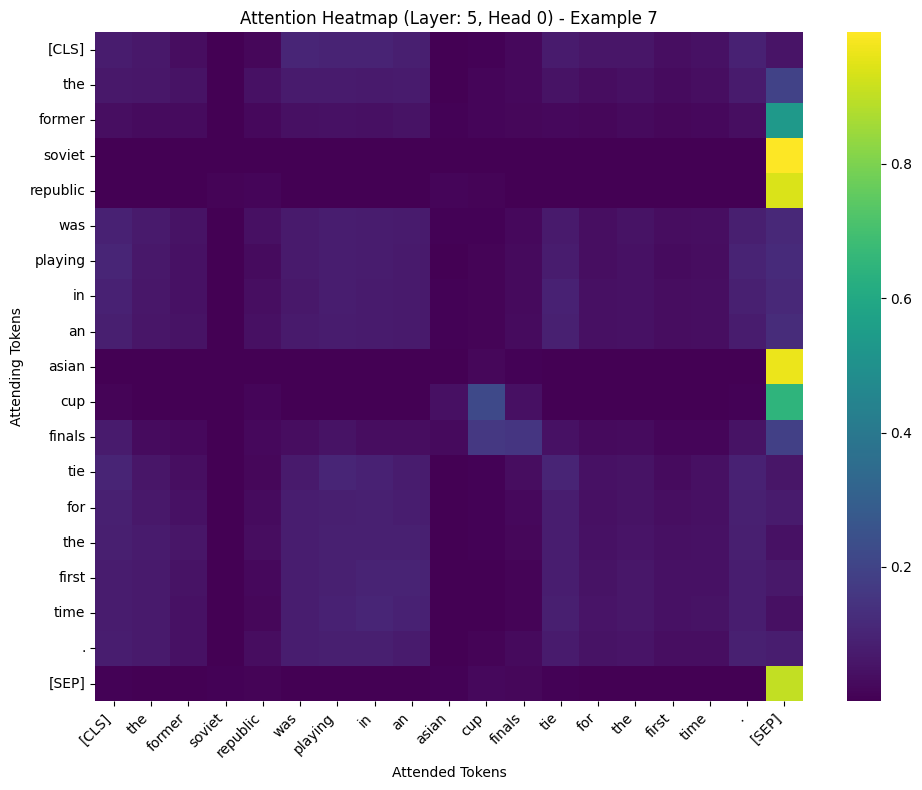

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

i, tokens, true_labels, pred_labels = misclassified_examples[2]
inputs = tokenizer(tokens, return_tensors="pt", is_split_into_words=True, truncation=True, padding=True, max_length=128)
inputs = {k: v.to(device) for k, v in inputs.items()}

model.eval()
with torch.no_grad():
    outputs = model(**inputs, output_attentions=True)

attentions = outputs.attentions

for layer in range(len(attentions)):
    attention = attentions[layer][0, 0].cpu().numpy()
    tokens_with_special = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])
    plt.figure(figsize=(10, 8))
    sns.heatmap(attention, xticklabels=tokens_with_special, yticklabels=tokens_with_special, cmap="viridis")
    plt.title(f"Attention Heatmap (Layer: {layer}, Head 0) - Example {i}")
    plt.xlabel("Attended Tokens")
    plt.ylabel("Attending Tokens")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

From these heatmaps, we focus on high attention units for figuring out observations.

Firstly, we could see a strong diagonal, which reflects the self-attentnion.

Then, we look for attention between related tokens. For example, in layer 4, the attention from `soviet` to `republic` indicates the wrong prediction of `I-LOC` which supposed to be `0`. The relatively highlighted unit between `asian` and `cup` reflects the successful observations of `B-MISC` and `I-MISC`.

Last but not the least, from the last layer's heatmap, we could see highlights on `[SEP]` column, which are the ones that are explicitly tagged, which shows the sequence-level information's aggregation. As expected, `republic` is wrongly classified. 

For the explanation of such a phenomenon, in BERT-based models, `[SEP]` makes the end of the sequence and often acts as a "sink" for attention in later layers. This is because the model learns to use `[SEP]` as a structural cue to aggregate sequence-level information for classification tasks.

For its strengths, it technically grasps a good initial entity recognition and contextual understanding, while the weaknesses are obvious from the figures, where there are entity ambiguities, and `[SEP]` bias, etc.

### 5. Analysis and Reporting (5 Points)

- Provide detailed explanations outlining your approach, experimental results, visualizations, and critical reflections on the model's performance and interpretability.

In general, this model is a fine-tuned DistilBERT for NER task on CoNLL-2003 dataset, with 6 layers and 12 heads per layer.

For the metrices, decent indices are reached,  while the performance still has quite a few space for improvement. For example, lower precision compared to recall implies the model is over-predicting entities, possibly tagging `0` tokens as `LOC` or misclassifying `PER/MISC` as `LOC`, etc.

Yet still, the output of heatmaps are still quite not straightforward as expected on these keywords' correlating units, while the accuracy index is still ideal in general.

Possibly, a manual adjustment of the test set splitting could be executed, and more hyperparameters' adjustment could potentially twist and boost the performance.